In [21]:
import pandas as pd
import re
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import gensim
import string 

from datetime import datetime
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn import metrics
from sklearn.metrics import classification_report
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords
from collections import Counter

In [22]:
# Function to parse date
dateparse = lambda x: datetime.strptime(x, '%Y-%m-%d')

# Read CSV while parsing the dates
opinion_df = pd.read_csv('data/all_opinions.csv', parse_dates=['date_filed'], date_parser=dateparse)

# Get head of opinion DF
opinion_df.head()

,author_name,category,per_curiam,case_name,date_filed,federal_cite_one,absolute_url,cluster,year_filed,scdb_id,scdb_decision_direction,scdb_votes_majority,scdb_votes_minority,text
0,Justice Roberts,majority,False,McCutcheon v. Federal Election Comm'n,2014-04-02,NaN,https://www.courtlistener.com/opinion/2659301/...,https://www.courtlistener.com/api/rest/v3/clus...,2014,2013-033,1.0,5.0,4.0,There is no right more basic in our democracy ...
1,Justice Thomas,concurring,False,McCutcheon v. Federal Election Comm'n,2014-04-02,NaN,https://www.courtlistener.com/opinion/2659301/...,https://www.courtlistener.com/api/rest/v3/clus...,2014,2013-033,1.0,5.0,4.0,I adhere to the view that this Court’s decisio...
2,Justice Breyer,dissenting,False,McCutcheon v. Federal Election Comm'n,2014-04-02,NaN,https://www.courtlistener.com/opinion/2659301/...,https://www.courtlistener.com/api/rest/v3/clus...,2014,2013-033,1.0,5.0,4.0,"Nearly 40 years ago in Buckley v. Valeo, 424 U..."
3,Justice Taney,majority,False,Ex Parte Crenshaw,1841-02-18,40 U.S. 119,https://www.courtlistener.com/opinion/86166/ex...,https://www.courtlistener.com/api/rest/v3/clus...,1841,1841-005,2.0,9.0,0.0,This case was brought here by an appeal from t...
4,Justice Pitney,majority,False,Richards v. Washington Terminal Co.,1914-05-04,233 U.S. 546,https://www.courtlistener.com/opinion/98178/ri...,https://www.courtlistener.com/api/rest/v3/clus...,1914,1913-149,1.0,8.0,1.0,"Plaintiff in error, who was plaintiff below, c..."


In [23]:
opinion_df.dtypes

author_name                        object
category                           object
per_curiam                           bool
case_name                          object
date_filed                 datetime64[ns]
federal_cite_one                   object
absolute_url                       object
cluster                            object
year_filed                          int64
scdb_id                            object
scdb_decision_direction           float64
scdb_votes_majority               float64
scdb_votes_minority               float64
text                               object
dtype: object

# Data Cleaning

In [24]:
# Copy the main df
opinion_copy = opinion_df.copy()

# Get opinions in the past 50 years
above_1970 = opinion_copy[opinion_copy['date_filed'] > "1970-01-01"]

# Check the value
above_1970.head(3)

,author_name,category,per_curiam,case_name,date_filed,federal_cite_one,absolute_url,cluster,year_filed,scdb_id,scdb_decision_direction,scdb_votes_majority,scdb_votes_minority,text
0,Justice Roberts,majority,False,McCutcheon v. Federal Election Comm'n,2014-04-02,NaN,https://www.courtlistener.com/opinion/2659301/...,https://www.courtlistener.com/api/rest/v3/clus...,2014,2013-033,1.0,5.0,4.0,There is no right more basic in our democracy ...
1,Justice Thomas,concurring,False,McCutcheon v. Federal Election Comm'n,2014-04-02,NaN,https://www.courtlistener.com/opinion/2659301/...,https://www.courtlistener.com/api/rest/v3/clus...,2014,2013-033,1.0,5.0,4.0,I adhere to the view that this Court’s decisio...
2,Justice Breyer,dissenting,False,McCutcheon v. Federal Election Comm'n,2014-04-02,NaN,https://www.courtlistener.com/opinion/2659301/...,https://www.courtlistener.com/api/rest/v3/clus...,2014,2013-033,1.0,5.0,4.0,"Nearly 40 years ago in Buckley v. Valeo, 424 U..."


In [25]:
# Remove Justice Douglas given how his opinions is highly unusual
# Refer to https://www.thenation.com/article/archive/tragedy-william-o-douglas/
above_1970_no_douglas = above_1970[above_1970['author_name'] != 'Justice Douglas']

# Remove those texts with less than 3000 characters as these are recounting past opinions
# Refer to https://www.kaggle.com/gqfiddler/scotus-opinions description of the dataset
char_above3000_1970 = above_1970_no_douglas[above_1970_no_douglas['text'].str.len() > 3000]

# Checking values
char_above3000_1970.head(3)

,author_name,category,per_curiam,case_name,date_filed,federal_cite_one,absolute_url,cluster,year_filed,scdb_id,scdb_decision_direction,scdb_votes_majority,scdb_votes_minority,text
0,Justice Roberts,majority,False,McCutcheon v. Federal Election Comm'n,2014-04-02,NaN,https://www.courtlistener.com/opinion/2659301/...,https://www.courtlistener.com/api/rest/v3/clus...,2014,2013-033,1.0,5.0,4.0,There is no right more basic in our democracy ...
1,Justice Thomas,concurring,False,McCutcheon v. Federal Election Comm'n,2014-04-02,NaN,https://www.courtlistener.com/opinion/2659301/...,https://www.courtlistener.com/api/rest/v3/clus...,2014,2013-033,1.0,5.0,4.0,I adhere to the view that this Court’s decisio...
2,Justice Breyer,dissenting,False,McCutcheon v. Federal Election Comm'n,2014-04-02,NaN,https://www.courtlistener.com/opinion/2659301/...,https://www.courtlistener.com/api/rest/v3/clus...,2014,2013-033,1.0,5.0,4.0,"Nearly 40 years ago in Buckley v. Valeo, 424 U..."


In [26]:
# Drop values that are not relevant for our analysis
to_analyze = char_above3000_1970.drop(columns=['absolute_url', 'cluster', 'year_filed', 
                                      'scdb_id', 'date_filed', 'author_name', 'federal_cite_one',
                                       'scdb_decision_direction', 'scdb_votes_majority', 'scdb_votes_minority'])
# Check the new_df
to_analyze = to_analyze.reset_index(drop=True)

to_analyze.head(3)

,category,per_curiam,case_name,text
0,majority,False,McCutcheon v. Federal Election Comm'n,There is no right more basic in our democracy ...
1,concurring,False,McCutcheon v. Federal Election Comm'n,I adhere to the view that this Court’s decisio...
2,dissenting,False,McCutcheon v. Federal Election Comm'n,"Nearly 40 years ago in Buckley v. Valeo, 424 U..."


# Feature Engineering

1. Convert the per_curiam into target variables of 0 and 1
2. Convert the category into categorical variables
3. Text Preprocessing
4. Handle Unbalanced Data Issue

In [27]:
# Step 1: Convert the per_curiam to target variables of 0 and 1

# Function to convert to 0 and 1
def label(x):
    if x == 'False':
        return 0
    return 1

# Change the per curiam to be of string
to_analyze['per_curiam'] = to_analyze['per_curiam'].astype('str')

# Apply the values throughout
to_analyze['per_curiam_label'] = to_analyze['per_curiam'].apply(lambda x: label(x))

# Check the values
to_analyze['per_curiam_label'].value_counts()

0    8555
1     611
Name: per_curiam_label, dtype: int64

As seen above there is an issue with unbalanced data given we would have to address this issue later

In [28]:
# Step 2: Encode the category column variables

# Get the unique values
categories = to_analyze['category'].unique()

# Encoding dictionary
cat_dict = {}

# Store the keys in the dictionary
for i in range(len(categories)):
    cat_dict[categories[i]] = i
    
# Apply the values throughout
to_analyze['cat_labels'] = to_analyze['category'].apply(lambda x: cat_dict[x])

# Check the values
to_analyze['cat_labels'].value_counts()

0    4778
2    2330
1    1103
4     523
3     432
Name: cat_labels, dtype: int64

## Text Preprocessing

Steps to clean

1. Standardize punctuations
2. Remove redundant words first
    - Key things to remove:
        1. Cite as: .. (Indicates how to cite the case) (Regex to get)
        2. Previous citations (Indicates where to find his substantiation of his points) (Remove the ones that start with capital See)
        3. Current case name (lower and remove)
3. Remove unicode characters
4. Remove breakline characters

Steps to preprocess
1. Lower case
2. Remove punctuations
3. Remove stopwords
4. Stem/Lemmatize

In [29]:
# Function to preprocess text

def clean(x):
    
    # Split the case name into array for individual capitalizing
    case_name_array = x['case_name'].split()
    
    # Iterate through the words to capitalize
    for i in range(len(case_name_array)):
        
        # If word not versus, capitalize it to remove later
        if case_name_array[i] != 'v.':
            case_name_array[i] = case_name_array[i].upper()
    
    # Join the case name array together
    case_name = ' '.join(case_name_array)
    
    # 1. Standardizing some punctuations
    tmp = x['text'].replace('’', "'")
    tmp = tmp.replace('–', "-")
    tmp = re.sub(r'([.]\s+){2,10}', '', tmp)
    tmp = tmp.replace('[', '')
    tmp = tmp.replace(']', '')
    
    # 2. Remove redundant words
    
    # A. (i) Remove Cite as: since these are words that keep appearing at the bottom of the transcript for citation
    tmp = re.sub(r'Cite as:(.*?)\((\d{4})\)', '', tmp)
    
    # A. (ii) Remove Opinion of Justice given it is a demarcation of the transcript
    tmp = re.sub(r'Opinion\s(.*?)\n', '', tmp)
    
    # B. Remove Case Name
    tmp = re.sub(f'''{case_name}''', '', tmp)
    
    #B. Remove See ... (As these are citations of previous cases to be used)
    # Three Cases
    # i) See case and citation
    see_pattern = re.compile(r"See(.*?)(\)\.|\)\;|\d\.)", re.DOTALL)
    tmp = re.sub(see_pattern, '', tmp)
    
    # (ii) Remove quotes i.e. Herring v. New York, 422 U.S. 853, 862 (1975)
#     tmp = re.sub(r'', '', tmp)

#     print(tmp)
    
    # 3. Remove unicode characters in text
    tmp = re.sub(r'[^\x00-\x7F]+', '', tmp)
    
    # 4. Remove breakline in text
    
    # A. Embedded in the string (-\\n)
    tmp = re.sub(r'-\n\s{1,}', '', tmp)
    tmp = re.sub(r'-\n', '', tmp) 
    
    # B. Remove long breaks
    tmp = re.sub(r'\n\s+', ' ', tmp)
    
    # C. Remove the remaining breaklines
    tmp = re.sub(r'\n', ' ', tmp)
    
    # 5. Remove Numbers that demarcate sections of opinions
    tmp = re.sub(r'\s\d{1,}\s{2,}', ' ', tmp)
    
    return tmp

In [30]:
to_analyze['cleaned_text'] = to_analyze.apply(lambda x : clean(x), axis=1)

In [31]:
# Instantiate the set of stopwords
stopwords_set = set(stopwords.words('english'))

# Instantiate lemmatizer
lemmatizer = WordNetLemmatizer()

def preprocess(x):
    
    # 1. Lower case
    tmp = x.lower()
    
    # 2. Remove punctuations
    tmp = tmp.translate(str.maketrans('', '', string.punctuation))
    
    # 3. Tokenize the sentences
    tokens = word_tokenize(tmp)
    
    # 4. Remove stopwords
    no_stopwords = [word for word in tokens if word not in stopwords_set and word.isalpha()]
    
    # 5. Lemmatize
    lemma_text = ' '.join([lemmatizer.lemmatize(word) for word in no_stopwords])
    
    return lemma_text

In [42]:
to_analyze['preprocessed_text'] = to_analyze['cleaned_text'].apply(lambda x: preprocess(x))

to_analyze.head(3)

,category,per_curiam,case_name,text,per_curiam_label,cat_labels,cleaned_text,preprocessed_text
0,majority,False,McCutcheon v. Federal Election Comm'n,There is no right more basic in our democracy ...,0,0,There is no right more basic in our democracy ...,right basic democracy right participate electi...
1,concurring,False,McCutcheon v. Federal Election Comm'n,I adhere to the view that this Court’s decisio...,0,1,I adhere to the view that this Court's decisio...,adhere view court decision buckley v valeo u p...
2,dissenting,False,McCutcheon v. Federal Election Comm'n,"Nearly 40 years ago in Buckley v. Valeo, 424 U...",0,2,"Nearly 40 years ago in Buckley v. Valeo, 424 U...",nearly year ago buckley v valeo u per curiam c...


## Modelling

Compare model performance pre data pre-processing vs post-preprocessing

# Logistic Regression without preprocessing

In [45]:
# Prepare the training and test set
X_train, X_test, y_train, y_test = train_test_split(opinion_df['text'], opinion_df['per_curiam'], test_size = 0.2, random_state = 0)

# Convert words into TF-IDF vectors

# Instantiate TF-IDF Vectorizer
Tfidf_vect = TfidfVectorizer()

# Fit the list into the vectorizer
Tfidf_vect.fit(opinion_df['text'])

# Transform the words into TF-IDF vectors
X_train_Tfidf = Tfidf_vect.transform(X_train)
X_test_Tfidf = Tfidf_vect.transform(X_test)

# instantiate the model
logreg = LogisticRegression()

# fit the model with data
logreg.fit(X_train_Tfidf, y_train)

y_pred = logreg.predict(X_test_Tfidf)

Accuracy: 0.96
Precision: 0.94
Recall: 0.62 



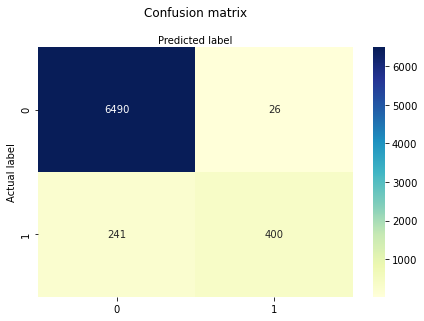

In [46]:
cnf_matrix = metrics.confusion_matrix(y_test, y_pred)

class_names = [False, True] # name  of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)

# create heatmap
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

print("Accuracy:", round(metrics.accuracy_score(y_test, y_pred),2))
print("Precision:", round(metrics.precision_score(y_test, y_pred),2))
print("Recall:", round(metrics.recall_score(y_test, y_pred),2), "\n")

In [47]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

       False       0.96      1.00      0.98      6516
        True       0.94      0.62      0.75       641

    accuracy                           0.96      7157
   macro avg       0.95      0.81      0.86      7157
weighted avg       0.96      0.96      0.96      7157



# Naive Bayes without preprocessing

In [48]:
clf = MultinomialNB()
clf.fit(X_train_Tfidf, y_train)
nb_y_pred = clf.predict(X_test_Tfidf)

Accuracy: 0.92
Precision: 1.0
Recall: 0.06 



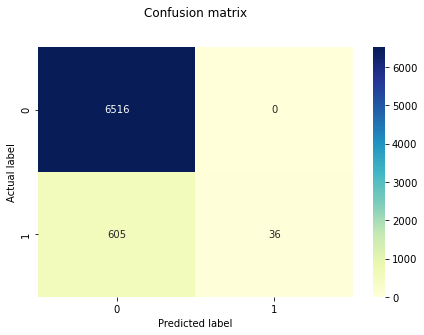

In [49]:
cnf_matrix = metrics.confusion_matrix(y_test, nb_y_pred)

# create heatmap
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

print("Accuracy:", round(metrics.accuracy_score(y_test, nb_y_pred),2))
print("Precision:", round(metrics.precision_score(y_test, nb_y_pred),2))
print("Recall:", round(metrics.recall_score(y_test, nb_y_pred),2), "\n")

In [50]:
print(classification_report(y_test, nb_y_pred))

              precision    recall  f1-score   support

       False       0.92      1.00      0.96      6516
        True       1.00      0.06      0.11       641

    accuracy                           0.92      7157
   macro avg       0.96      0.53      0.53      7157
weighted avg       0.92      0.92      0.88      7157



# Logistic Regegression post text pre-processing

In [53]:
X_train, X_test, y_train, y_test = train_test_split(to_analyze['preprocessed_text'], to_analyze['per_curiam_label'], test_size = 0.2, random_state=0)

# Convert words into TF-IDF vectors

# Instantiate TF-IDF Vectorizer
Tfidf_vect = TfidfVectorizer()

# Fit the list into the vectorizer
Tfidf_vect.fit(to_analyze['preprocessed_text'])

# Transform the words into TF-IDF vectors
X_train_Tfidf = Tfidf_vect.transform(X_train)
X_test_Tfidf = Tfidf_vect.transform(X_test)

# instantiate the model
logreg = LogisticRegression()

# fit the model with data
logreg.fit(X_train_Tfidf, y_train)

y_pred = logreg.predict(X_test_Tfidf)

Accuracy: 0.93
Precision: 1.0
Recall: 0.08 



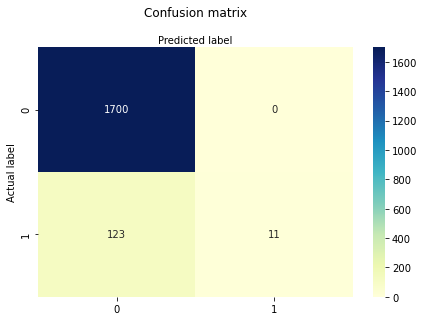

In [54]:
cnf_matrix = metrics.confusion_matrix(y_test, y_pred)

class_names = [False, True] # name  of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)

# create heatmap
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

print("Accuracy:", round(metrics.accuracy_score(y_test, y_pred),2))
print("Precision:", round(metrics.precision_score(y_test, y_pred),2))
print("Recall:", round(metrics.recall_score(y_test, y_pred),2), "\n")

In [55]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.93      1.00      0.97      1700
           1       1.00      0.08      0.15       134

    accuracy                           0.93      1834
   macro avg       0.97      0.54      0.56      1834
weighted avg       0.94      0.93      0.91      1834



# Naive Bayes Post text pre-processing

In [56]:
clf = MultinomialNB()
clf.fit(X_train_Tfidf, y_train)
nb_y_pred = clf.predict(X_test_Tfidf)

Accuracy: 0.93
Precision: 0.0
Recall: 0.0 



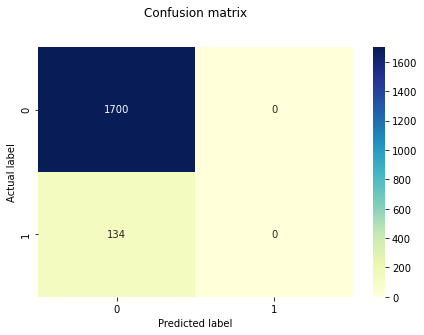

In [57]:
cnf_matrix = metrics.confusion_matrix(y_test, nb_y_pred)

# create heatmap
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

print("Accuracy:", round(metrics.accuracy_score(y_test, nb_y_pred),2))
print("Precision:", round(metrics.precision_score(y_test, nb_y_pred),2))
print("Recall:", round(metrics.recall_score(y_test, nb_y_pred),2), "\n")

In [58]:
print(classification_report(y_test, nb_y_pred))

              precision    recall  f1-score   support

           0       0.93      1.00      0.96      1700
           1       0.00      0.00      0.00       134

    accuracy                           0.93      1834
   macro avg       0.46      0.50      0.48      1834
weighted avg       0.86      0.93      0.89      1834



In [59]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D
from keras.utils.np_utils import to_categorical
from keras.callbacks import EarlyStopping
from keras.layers import Dropout

In [60]:
# The maximum number of words to be used. (most frequent)
MAX_NB_WORDS = 50000

# Max number of words in each complaint.
MAX_SEQUENCE_LENGTH = 500

EMBEDDING_DIM = 100

tokenizer = Tokenizer(num_words=MAX_NB_WORDS, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)
tokenizer.fit_on_texts(to_analyze['preprocessed_text'].values)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 123772 unique tokens.


In [61]:
X = tokenizer.texts_to_sequences(to_analyze['preprocessed_text'].values)
X = pad_sequences(X, maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of data tensor:', X.shape)

Shape of data tensor: (9166, 500)


In [62]:
from sklearn.model_selection import train_test_split

y = to_analyze['per_curiam_label'].tolist()

Y = pd.get_dummies(to_analyze['per_curiam_label']).values
print('Shape of label tensor:', Y.shape)

X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.20, random_state = 0)

Shape of label tensor: (9166, 2)


In [63]:
model = Sequential()
model.add(Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=X.shape[1]))
model.add(SpatialDropout1D(0.2))
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(2, activation='softmax'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

epochs = 10
batch_size = 100

results = model.fit(X_train, Y_train, epochs=epochs, batch_size=batch_size,validation_split=0.1,callbacks=[EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)])

Epoch 1/10
66/66 [==============================] - 345s 5s/step - loss: 0.3038 - accuracy: 0.9265 - val_loss: 0.2164 - val_accuracy: 0.9387
Epoch 2/10
66/66 [==============================] - 360s 5s/step - loss: 0.1714 - accuracy: 0.9465 - val_loss: 0.1598 - val_accuracy: 0.9496
Epoch 3/10
66/66 [==============================] - 364s 6s/step - loss: 0.0972 - accuracy: 0.9667 - val_loss: 0.1657 - val_accuracy: 0.9469
Epoch 4/10
66/66 [==============================] - 375s 6s/step - loss: 0.0738 - accuracy: 0.9779 - val_loss: 0.1803 - val_accuracy: 0.9441
Epoch 5/10
66/66 [==============================] - 385s 6s/step - loss: 0.0592 - accuracy: 0.9774 - val_loss: 0.2534 - val_accuracy: 0.9510


In [64]:
accr = model.evaluate(X_test,Y_test)

print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))

58/58 [==============================] - 11s 190ms/step - loss: 0.2343 - accuracy: 0.9455
Test set
  Loss: 0.234
  Accuracy: 0.945


In [70]:
# Predict test data
y_sub_hat_ = model.predict(X_test)
y_nn_pred = [np.argmax(x) for x in y_sub_hat_]

# Use classification report function to get confusion matrix
print(classification_report(y_test, y_nn_pred))

              precision    recall  f1-score   support

           0       0.95      0.99      0.97      1700
           1       0.76      0.37      0.50       134

    accuracy                           0.95      1834
   macro avg       0.86      0.68      0.74      1834
weighted avg       0.94      0.95      0.94      1834

